<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
توضیحات : در این سوال هدف ترین کردن مدلی برای تشخیص دو کلاس از Cifr10 با استفاده از مدل ترین شده alexnet است.
<br>

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت ابتدا دیتاست Cifar10 دانلود شده مورد استفاده قرار می گیرد.
دیتالودر موردنظر روی دو کلاس موردنظر ساخته و ترنسفورم روی آن اعمال می شود.
<br>

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = dsets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = dsets.CIFAR10(root='./data', train=False, download=True, transform=transform)

selected_classes = [0, 1]
train_filtered_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] in selected_classes]
test_filtered_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] in selected_classes]

subset_train_dataset = torch.utils.data.Subset(train_dataset, train_filtered_indices)
subset_test_dataset = torch.utils.data.Subset(test_dataset, test_filtered_indices)
print(len(subset_train_dataset))
print(len(subset_test_dataset))


Files already downloaded and verified
Files already downloaded and verified
10000
2000


In [ ]:
expected_labels = {0 : 0 , 1: 1}
labels = [expected_labels[label] for label in train_dataset.targets if label in expected_labels]
print((labels[0:10]))

[1, 1, 0, 0, 1, 0, 1, 1, 1, 0]


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت تابعی چهت ترین کردن مدل نوشته می شود.
روند تابع به شکل کلی به این صورت است که نتایج واقعی و حاصل از مدل مقایسه شده و با استفاده از تابع لاس موردنظر وزن ها به تدریج برحسب lr موردنظر آپدیت می شوند.
در انتها نتایج روی داده های تست نیز گزارش می شود.
<br>

In [ ]:
from tqdm import tqdm

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device="cpu"):
    model.to(device)
    train_acc = []
    loss_list = []
    test_acc = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_acc.append(train_accuracy)
        # Validation
        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        test_accuracy = correct_val / total_val
        test_acc.append(test_accuracy)
        loss_list.append(average_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {average_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {test_accuracy:.4f}')

    return train_acc, test_acc, loss_list

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این قسمت ابتدا مدل alexnet فراخوانی شده و لایه آخر آن به 2 کلاس خروجی تغییر می یابد.
<br>

In [ ]:
import torch.nn as nn
import torchvision.models as models

alexnet = models.alexnet(pretrained=True)

num_classes_cifar = 2
alexnet.classifier[-1] = nn.Linear(4096, num_classes_cifar)

print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
نهایتا توابع لاس و بهینه ساز انتخاب شده و نتایج train acc , test acc گزارش می شود.
ذیل ، val acc همان نتایج روی داده تست است.
<br>

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

train_loader = DataLoader(subset_train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(subset_test_dataset, batch_size=128, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001)

tain_acc, val_acc, loss_list = train(alexnet, train_loader, test_loader, criterion, optimizer, num_epochs=10, device = device)

cuda


100%|██████████| 16/16 [00:04<00:00,  3.73it/s]


Epoch [1/10], Training Loss: 0.3200, Training Accuracy: 0.8797, Validation Accuracy: 0.9375


100%|██████████| 16/16 [00:04<00:00,  3.67it/s]


Epoch [2/10], Training Loss: 0.1663, Training Accuracy: 0.9401, Validation Accuracy: 0.9525


100%|██████████| 16/16 [00:04<00:00,  3.70it/s]


Epoch [3/10], Training Loss: 0.1360, Training Accuracy: 0.9508, Validation Accuracy: 0.9585


100%|██████████| 16/16 [00:04<00:00,  3.73it/s]


Epoch [4/10], Training Loss: 0.1186, Training Accuracy: 0.9569, Validation Accuracy: 0.9610


100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


Epoch [5/10], Training Loss: 0.1091, Training Accuracy: 0.9603, Validation Accuracy: 0.9585


100%|██████████| 16/16 [00:04<00:00,  3.69it/s]


Epoch [6/10], Training Loss: 0.1007, Training Accuracy: 0.9634, Validation Accuracy: 0.9475


100%|██████████| 16/16 [00:04<00:00,  3.67it/s]


Epoch [7/10], Training Loss: 0.0905, Training Accuracy: 0.9682, Validation Accuracy: 0.9690


100%|██████████| 16/16 [00:04<00:00,  3.67it/s]


Epoch [8/10], Training Loss: 0.0858, Training Accuracy: 0.9683, Validation Accuracy: 0.9710


100%|██████████| 16/16 [00:04<00:00,  3.70it/s]


Epoch [9/10], Training Loss: 0.0837, Training Accuracy: 0.9698, Validation Accuracy: 0.9640


100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

Epoch [10/10], Training Loss: 0.0812, Training Accuracy: 0.9701, Validation Accuracy: 0.9630


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=5>
رسم نمودار دقت ترین
<br>
رسم نمودار لاس
<br>
رسم نمودار دقت تست
<br>


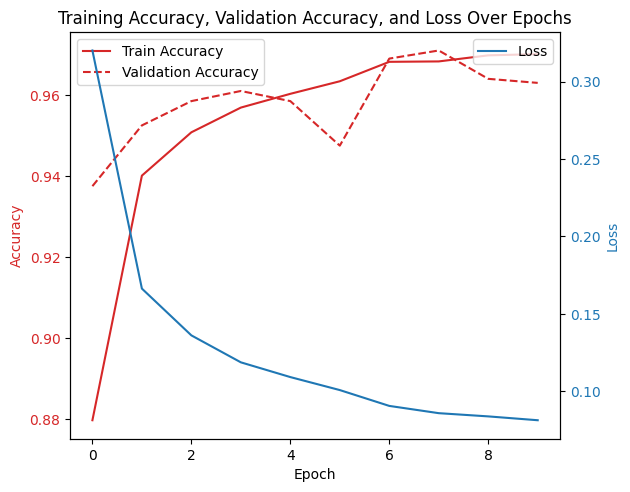

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(tain_acc, label='Train Accuracy', color=color)
ax1.plot(val_acc, label='Validation Accuracy', linestyle='dashed', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(loss_list, label='Loss', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Training Accuracy, Validation Accuracy, and Loss Over Epochs')
plt.show()
